In [1]:
!pip install pyaurn

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output

In [3]:
metadata = pyaurn.importMeta().set_index("site_id")

In [16]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [7]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["day"] = data["date"].dt.day
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    data["hour"] = data["date"].dt.hour
    if "PM2.5" in data.columns:
      data = data[["day", "month", "year", "hour", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [17]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [18]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,day,month,year,hour,PM2.5,location_type,latitude,longitude
0,1,1,2021,0,29.316,Urban Background,51.449674,-0.037418
1,1,1,2021,1,19.293,Urban Background,51.449674,-0.037418
2,1,1,2021,2,16.604,Urban Background,51.449674,-0.037418
3,1,1,2021,3,15.330,Urban Background,51.449674,-0.037418
4,1,1,2021,4,17.807,Urban Background,51.449674,-0.037418
...,...,...,...,...,...,...,...,...
656745,20,9,2021,7,2.288,Urban Background,57.157360,-2.094278
656746,20,9,2021,8,2.123,Urban Background,57.157360,-2.094278
656747,20,9,2021,9,1.722,Urban Background,57.157360,-2.094278
656748,20,9,2021,10,1.580,Urban Background,57.157360,-2.094278


In [19]:
dataset_length = len(concatenated_data)

#train_dataset = concatenated_data[0:int(0.7*dataset_length)]
#val_dataset = concatenated_data[int(0.7*dataset_length):int(0.9*dataset_length)]
#test_dataset = concatenated_data[int(0.9*dataset_length):]

train_dataset = concatenated_data.sample(frac=0.7)
val_dataset = concatenated_data.drop(train_dataset.index).sample(frac=0.66)
test_dataset = concatenated_data.drop(train_dataset.index).drop(val_dataset.index)
display(train_dataset)
display(val_dataset)
display(test_dataset)

,day,month,year,hour,PM2.5,location_type,latitude,longitude
592833,10,7,2021,11,11.000,Urban Traffic,50.735454,-1.780888
33128,29,11,2021,6,19.929,Urban Background,53.028210,-2.175133
463908,11,2,2021,22,19.000,Suburban Background,51.452580,0.070766
24372,25,11,2021,14,-1.000,Urban Industrial,51.583950,-3.770822
297345,8,1,2021,0,4.033,Rural Background,54.439510,-7.900328
...,...,...,...,...,...,...,...,...
69656,18,6,2021,12,5.330,Urban Traffic,52.476145,-1.874978
165604,17,1,2021,22,0.000,Urban Background,54.569297,-1.220874
265090,10,2,2021,8,20.000,Urban Background,51.481780,-3.176250
135241,26,9,2021,4,17.052,Urban Background,53.748780,-0.341222


,day,month,year,hour,PM2.5,location_type,latitude,longitude
25566,14,1,2021,17,4.788,Urban Background,53.028210,-2.175133
214645,16,2,2021,10,14.009,Rural Background,51.782616,-4.692370
462596,5,12,2021,3,2.665,Urban Background,55.945589,-3.182186
178574,17,8,2021,2,3.000,Urban Background,51.453090,-0.944067
620395,31,10,2021,2,8.000,Urban Traffic,54.516667,-1.358547
...,...,...,...,...,...,...,...,...
80451,9,10,2021,1,8.000,Urban Traffic,51.074793,-4.041924
630896,21,1,2021,9,1.000,Urban Background,51.462839,-2.584482
72433,13,10,2021,7,14.552,Urban Traffic,52.476145,-1.874978
264906,2,2,2021,16,10.000,Urban Background,51.481780,-3.176250


,day,month,year,hour,PM2.5,location_type,latitude,longitude
7,1,1,2021,7,19.363,Urban Background,51.449674,-0.037418
17,1,1,2021,17,38.090,Urban Background,51.449674,-0.037418
18,1,1,2021,18,33.750,Urban Background,51.449674,-0.037418
23,1,1,2021,23,11.321,Urban Background,51.449674,-0.037418
27,2,1,2021,3,8.231,Urban Background,51.449674,-0.037418
...,...,...,...,...,...,...,...,...
656688,17,9,2021,22,11.109,Urban Background,57.157360,-2.094278
656697,18,9,2021,7,3.632,Urban Background,57.157360,-2.094278
656702,18,9,2021,12,1.604,Urban Background,57.157360,-2.094278
656736,19,9,2021,22,2.547,Urban Background,57.157360,-2.094278


In [22]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")

train_features.shape

(459725, 7)

In [23]:
def split_data_for_preprocessing(dataset):
  text_cols = ["location_type"]
  number_cols = ["day", "month", "year", "hour", "latitude", "longitude"]

  return (dataset[number_cols], dataset[text_cols])

In [24]:
train_features_split = split_data_for_preprocessing(train_features)
val_features_split = split_data_for_preprocessing(val_features)
test_features_split = split_data_for_preprocessing(test_features)

print(train_features_split[0].info())
print(train_features_split[1].info())
print(pd.unique(train_features_split[1]["location_type"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 592833 to 83648
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   day        459725 non-null  int64  
 1   month      459725 non-null  int64  
 2   year       459725 non-null  int64  
 3   hour       459725 non-null  int64  
 4   latitude   459725 non-null  float64
 5   longitude  459725 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 24.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 592833 to 83648
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   location_type  459725 non-null  object
dtypes: object(1)
memory usage: 7.0+ MB
None
['Urban Traffic' 'Urban Background' 'Suburban Background'
 'Urban Industrial' 'Rural Background']


In [26]:
vocabulary = np.array(pd.unique(train_features["location_type"]))
category_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocabulary, output_mode="multi_hot")(category_inputs)

numeric_inputs = tf.keras.layers.Input(shape=(6,))
normalisation_layer = tf.keras.layers.Normalization()
normalisation_layer.adapt(train_features_split[0])
normalisation_layer = normalisation_layer(numeric_inputs)

concatenated_inputs = tf.keras.layers.concatenate([lookup_layer, normalisation_layer])
dense_layer = tf.keras.layers.Dense(32, activation="tanh")(concatenated_inputs)
outputs = tf.keras.layers.Dense(1)(dense_layer)

model = tf.keras.Model(inputs=[category_inputs, numeric_inputs], outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
string_lookup_1 (StringLookup)  (None, 6)            0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 6)            13          input_4[0][0]                    
______________________________________________________________________________________________

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [28]:
print(train_features.dtypes)
history = model.fit(
    (train_features_split[1], train_features_split[0]),
    train_labels,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    ],
    validation_data = ((val_features_split[1], val_features_split[0]), val_labels)
)

day                int64
month              int64
year               int64
hour               int64
location_type     object
latitude         float64
longitude        float64
dtype: object
Epoch 1/10
14367/14367 [==============================] - 85s 6ms/step - loss: 40.3220 - mean_absolute_error: 4.3133 - val_loss: 37.5856 - val_mean_absolute_error: 4.0966
Epoch 2/10
14367/14367 [==============================] - 78s 5ms/step - loss: 38.0215 - mean_absolute_error: 4.1965 - val_loss: 36.9566 - val_mean_absolute_error: 4.2933
Epoch 3/10
14367/14367 [==============================] - 86s 6ms/step - loss: 37.0020 - mean_absolute_error: 4.1418 - val_loss: 35.3515 - val_mean_absolute_error: 3.8896
Epoch 4/10
14367/14367 [==============================] - 86s 6ms/step - loss: 36.4362 - mean_absolute_error: 4.1068 - val_loss: 36.4550 - val_mean_absolute_error: 3.9860
Epoch 5/10
14367/14367 [==============================] - 86s 6ms/step - loss: 33.4114 - mean_absolute_error: 3.8928 - val_loss

{'loss': [40.32198715209961,
  38.021480560302734,
  37.00202560424805,
  36.43617630004883,
  33.41140365600586,
  33.175743103027344,
  33.13562774658203,
  33.069820404052734,
  32.550697326660156,
  32.51678466796875],
 'mean_absolute_error': [4.313282012939453,
  4.196462154388428,
  4.1417670249938965,
  4.106827259063721,
  3.8927953243255615,
  3.883467197418213,
  3.8809587955474854,
  3.8771727085113525,
  3.8393967151641846,
  3.8369805812835693],
 'val_loss': [37.5855827331543,
  36.9565544128418,
  35.35154724121094,
  36.4549674987793,
  32.544864654541016,
  32.46890640258789,
  32.33651351928711,
  32.41423797607422,
  31.95962142944336,
  31.874309539794922],
 'val_mean_absolute_error': [4.096646785736084,
  4.293298244476318,
  3.8895514011383057,
  3.9859657287597656,
  3.935126543045044,
  3.825436592102051,
  3.8325276374816895,
  3.851433277130127,
  3.825364351272583,
  3.8402302265167236],
 'lr': [0.1,
  0.1,
  0.1,
  0.1,
  0.02,
  0.02,
  0.02,
  0.02,
  0.003

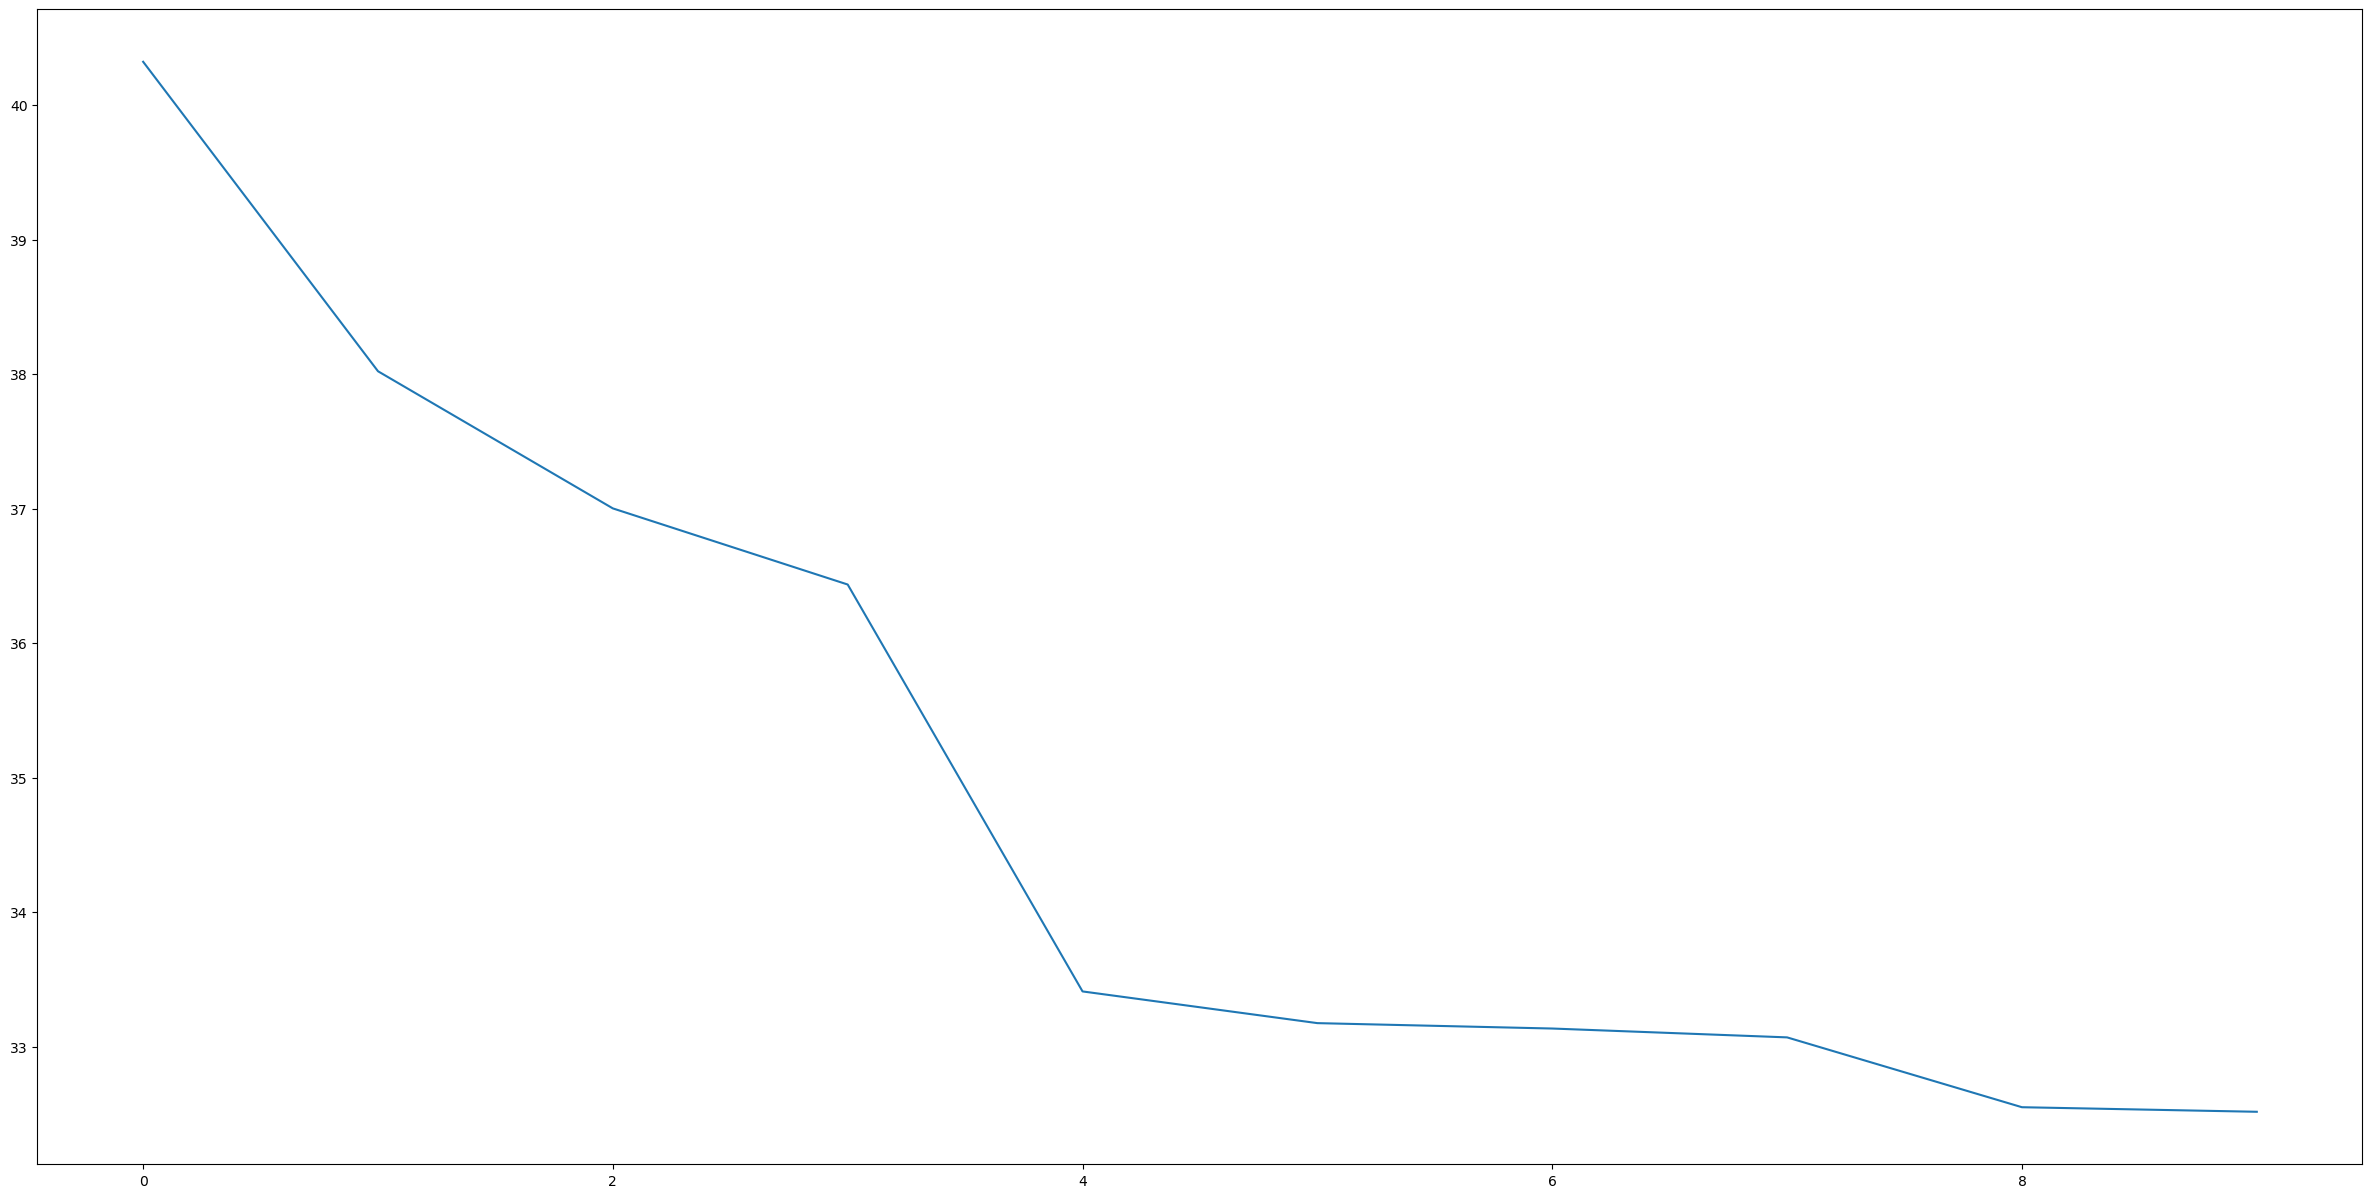

In [29]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

array([ 9.376132 ,  9.878443 , 11.509269 , ...,  1.8501272,  3.224554 ,
        2.5677242], dtype=float32)

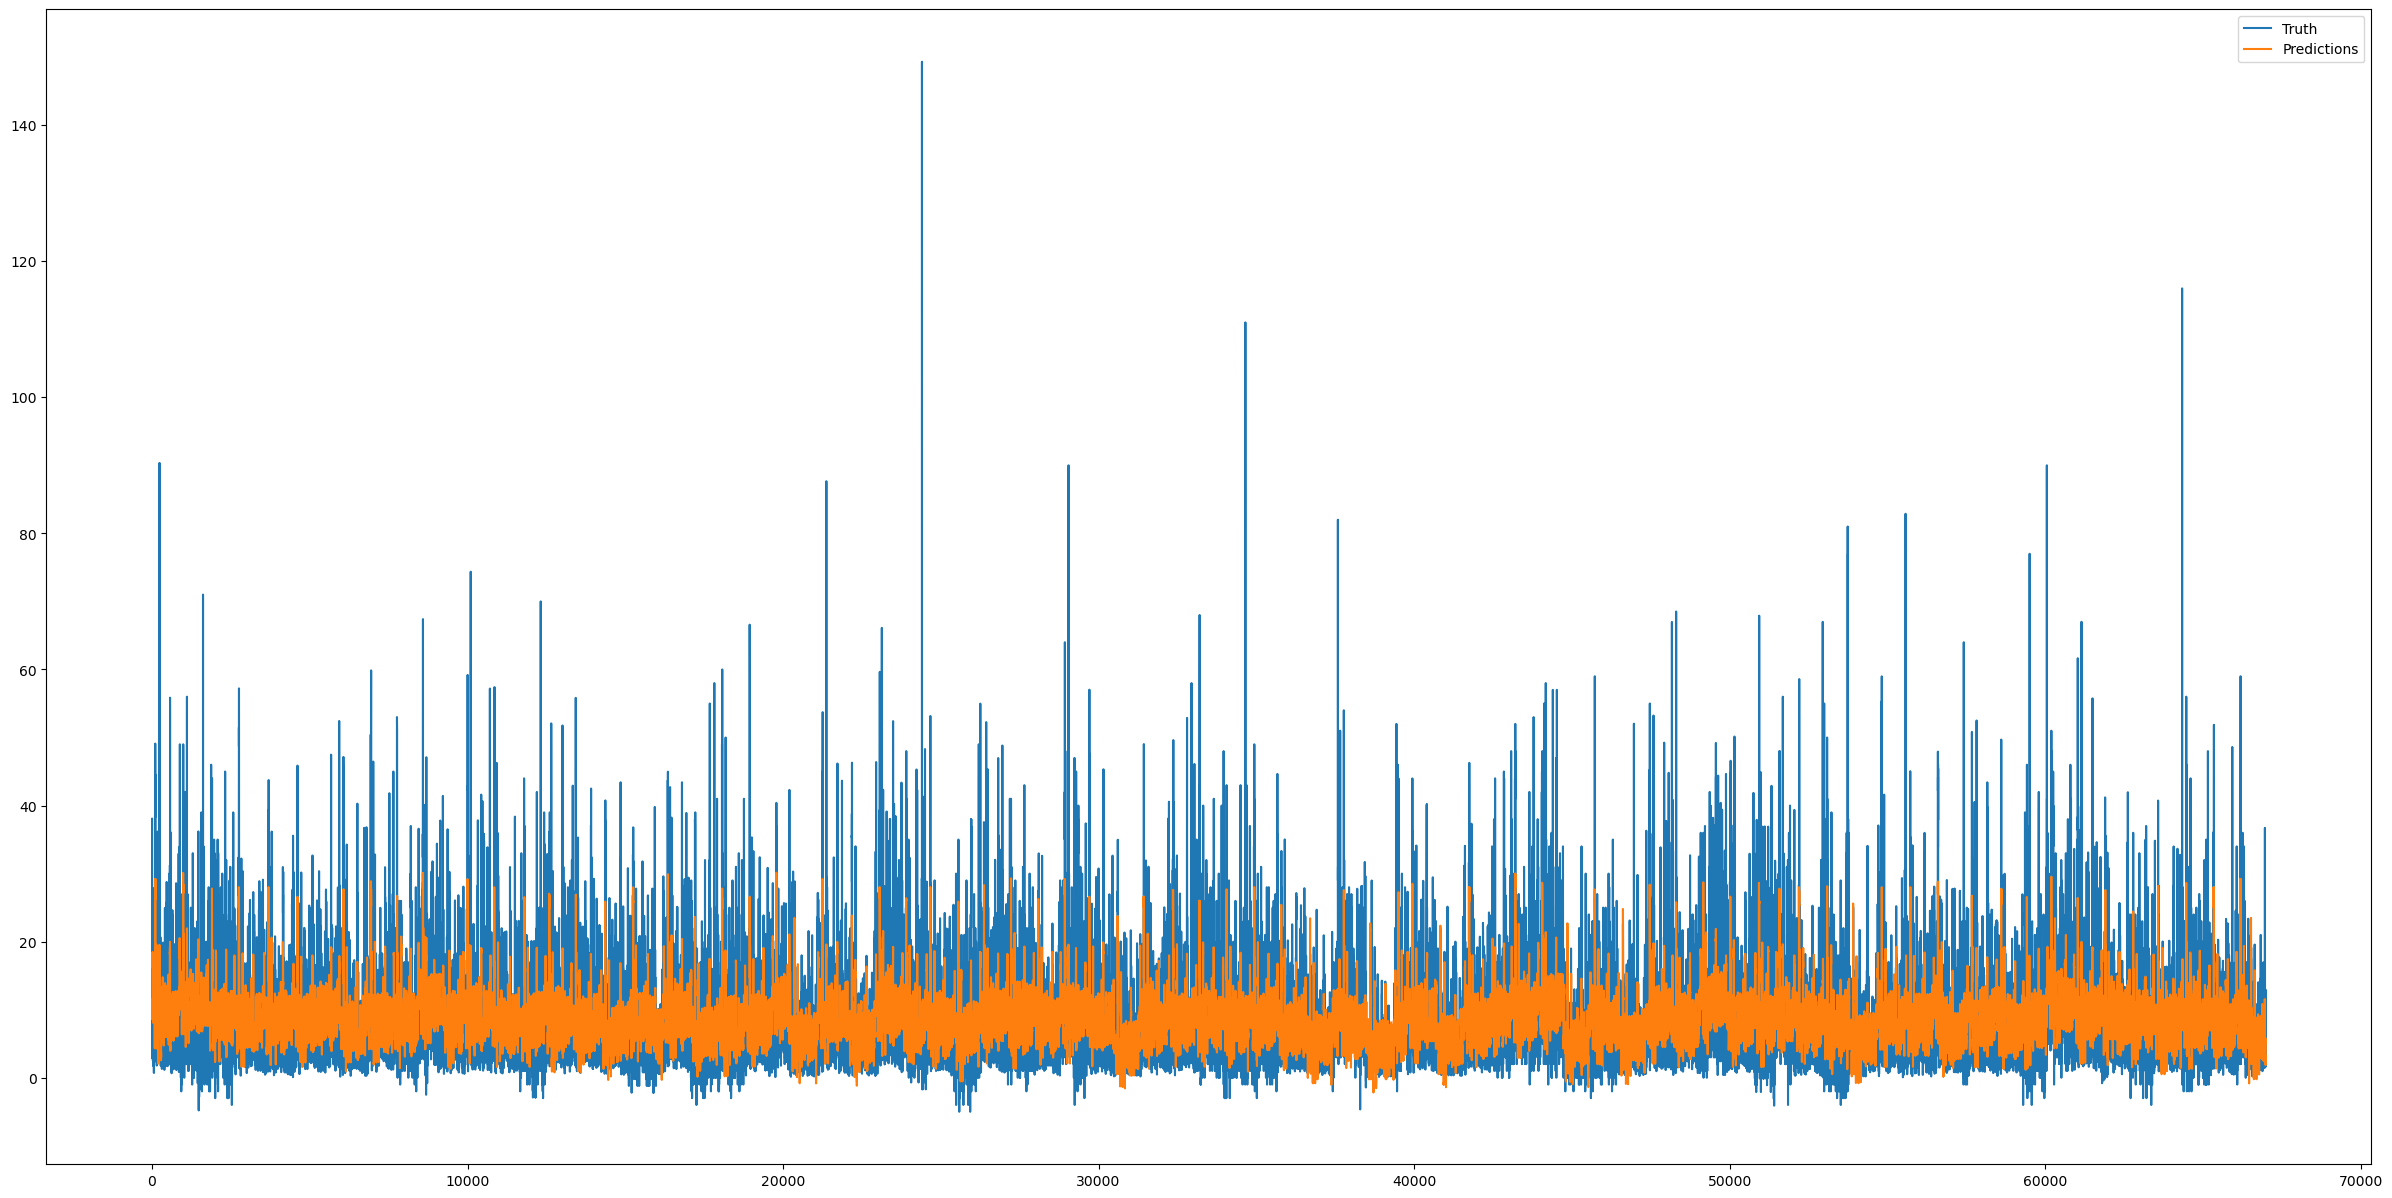

In [30]:
predictions = model.predict([test_features_split[1], test_features_split[0]]).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [31]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()

INFO:tensorflow:Assets written to: /content/comp3000model\assets
